In [22]:
import pandas as pd
import tomotopy as tp
import gensim
import collections
import pyLDAvis
import matplotlib.pyplot as plt
import matplotlib.colors as clr

In [23]:
df = pd.read_pickle('stemming_data.pkl')
nums = []
for i in df['Lemmatized']:
    nums.append(len(i))
df['nums'] = nums
df = df.drop(df[df['nums'] < 3].index)
df = df.reindex(columns=['Lemmatized', 'Positive=1'])
df = df.reset_index(drop=True)
df = df.rename(columns={'Positive=1':'recommend=1'})

In [28]:
def get_coherence(model, coherence=None, topn=None, processes=None):
    
    topics = []
    for k in range(model.k):
        word_probs = model.get_topic_words(k, topn)
        topics.append([word for word, prob in word_probs])
     
    texts = []
    corpus = []
    for doc in model.docs:
        words = [model.vocabs[token_id] for token_id in doc.words]
        texts.append(words)
        freqs = list(collections.Counter(doc.words).items())                  
        corpus.append(freqs)
    
    id2word = dict(enumerate(model.vocabs))
    dictionary = gensim.corpora.dictionary.Dictionary.from_corpus(corpus, id2word)
    
    cm = gensim.models.coherencemodel.CoherenceModel(
        topics=topics,
        texts=texts,
        corpus=corpus,
        dictionary=dictionary,  
        coherence=coherence,
        topn=topn,
        processes=processes,
    )

    return cm.get_coherence()

def compute_coherence_values(start, limit, step):
   
    for j in range(start, limit+1, step):                  
        #mdl = tp.SLDAModel(min_cf=3, k=j, vars='b', glm_param=5,seed = 2021711695)
        mdl = tp.LDAModel(k=j)
        for i in range(0,len(Content)):
            if not len(Content[i]) == 0:
                mdl.add_doc(Content[i], y=[float(recommendations[i])])   
                
        mdl.train(iter=50, workers=0)             
        
        coherence_value = get_coherence(mdl, coherence='c_v', topn=10, processes=5)

        print(f'Topic: {j}\tLog-likelihood: {mdl.ll_per_word}\tCoherence: {coherence_value}\tPerplexity: {mdl.perplexity}')
        
        coherence_values.append(coherence_value) 
        perplexities.append(mdl.perplexity)
        mdl.save(f'./models/k={j}_mdl_result.bin')


In [29]:
Content = df['Lemmatized'].values.tolist()
recommendations = df['recommend=1'].values.tolist()

coherence_values = []
perplexities = []  

limit = 30
start = 10
step = 1

compute_coherence_values(start, limit, step)


Topic: 10	Log-likelihood: -7.8815661767185015	Coherence: 0.5371884567227334	Perplexity: 2648.016575635803
Topic: 11	Log-likelihood: -7.938386991152534	Coherence: 0.5423449666985644	Perplexity: 2802.8358610916857
Topic: 12	Log-likelihood: -7.966298330871429	Coherence: 0.5454256440623934	Perplexity: 2882.1687584677934
Topic: 13	Log-likelihood: -8.000867123786318	Coherence: 0.5623864683512168	Perplexity: 2983.543967638915
Topic: 14	Log-likelihood: -8.011749640333809	Coherence: 0.5580926706655674	Perplexity: 3016.1897461657
Topic: 15	Log-likelihood: -8.020847163671121	Coherence: 0.5259951468706446	Perplexity: 3043.754799511207
Topic: 16	Log-likelihood: -8.054967236972036	Coherence: 0.5397667011844983	Perplexity: 3149.399998380349
Topic: 17	Log-likelihood: -8.041942039526575	Coherence: 0.5436929137090932	Perplexity: 3108.6444423485013
Topic: 18	Log-likelihood: -8.084849046700677	Coherence: 0.5570696485517643	Perplexity: 3244.929965746028
Topic: 19	Log-likelihood: -8.07093008973837	Coherence

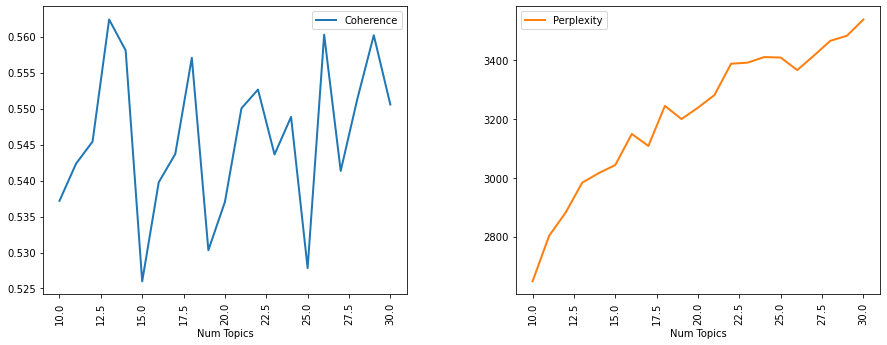

In [30]:
x = range(start, limit+1, step)

mdl_check = pd.DataFrame(list(zip(x, coherence_values, perplexities)), columns=['Num Topics', 'Coherence', 'Perplexity'])
mdl_check.to_csv(f'./models/mdl_check_{start}to{limit},{step}.csv', index =False)

plt.rcParams["figure.figsize"] = (40,10)
plt.rcParams.update({'font.size': 10})
plt.rcParams['lines.linewidth'] = 2

fig, ax = plt.subplots(figsize=(15,5), nrows=1, ncols=2)

plt.subplots_adjust(left=0.125,bottom=0.1,right=0.9,top=0.9,wspace=0.3,hspace=0.5)
#plt.title(f'Coherence & Perplexity')
pd.pivot_table(mdl_check, values=["Perplexity", "Coherence"],index="Num Topics").plot(kind='line', rot=90, ax=ax, subplots=True)

# Coherence 높, Perplexity 낮

plt.savefig('./models/searchK.png')

In [37]:
topicnums = []
for num in range(1,limit+1,step):
    topicnums.append(f'topic_{num}')

searchtopics = pd.DataFrame(topicnums,columns = ['topic_num'])

for num in range(start,limit+1,step):
    model = f'./models/k={num}_mdl_result.bin'
    #mdl = tp.SLDAModel.load(model)
    mdl = tp.LDAModel.load(model)

    topic_word = []
    topicw = []
    topics = []

    for k in range(mdl.k):
        i = mdl.get_topic_words(k, top_n=20)
        topicw = []
        for j in i:
            topicw.append(j[0])
        topic_word.append(topicw)

    for i in topic_word:
        x = ''
        for j in range(20):
            x += str(i[j])
            if not j == 19:
                x+= ', '

        topics.append(x)

    topicsdf = pd.DataFrame(topics,columns = [f'topic_max_{num}'])
    searchtopics = searchtopics.join(topicsdf, how='left')
   
    if num % 5 == 0:
        print(num)

searchtopics.to_csv('./models/searchK_topicwords.csv', index=False,  encoding='utf-8-sig')

10
15
20
25
30


In [ ]:
j = 13
mdl = tp.SLDAModel.load(f'./models/k={j}_mdl_result.bin')

In [40]:
for k, coef in enumerate(mdl.get_regression_coef(0)):
    print('#{} ({})'.format(k+1, coef))

#1 (-1.9262473583221436)
#2 (11.536559104919434)
#3 (7.191921710968018)
#4 (3.1414377689361572)
#5 (1.6121803522109985)
#6 (7.46111536026001)
#7 (-24.390491485595703)
#8 (13.069840431213379)
#9 (1.6674870252609253)
#10 (6.129167079925537)
#11 (-12.365777015686035)
#12 (8.040138244628906)
#13 (-7.723370552062988)
#14 (10.293327331542969)
#15 (-19.112407684326172)
#16 (-9.635162353515625)
#17 (13.937816619873047)
#18 (14.44180965423584)
#19 (9.208754539489746)
#20 (13.201610565185547)
#21 (-10.701952934265137)


In [41]:
mdl.summary()

<Basic Info>
| SLDAModel (current version: 0.12.0)
| 49003 docs, 1259364 words
| Total Vocabs: 29282, Used Vocabs: 10018
| Entropy of words: -6.99549
| Removed Vocabs: <NA>
|
<Training Info>
| Iterations: 50, Burn-in steps: 0
| Optimization Interval: 10
| Log-likelihood per word: -7.92071
|
<Initial Parameters>
| tw: TermWeight.ONE
| min_cf: 3 (minimum collection frequency of words)
| min_df: 0 (minimum document frequency of words)
| rm_top: 0 (the number of top words to be removed)
| k: 21 (the number of topics between 1 ~ 32767)
| vars: binary
| alpha: [0.1] (hyperparameter of Dirichlet distribution for document-topic, given as a single `float` in case of symmetric prior and as a list with length `k` of `float` in case of asymmetric prior.)
| eta: 0.01 (hyperparameter of Dirichlet distribution for topic-word)
| mu: [] (mean of regression coefficients, default value is 0)
| nu_sq: [] (variance of regression coefficients, default value is 1)
| glm_param: [5.] (the parameter for General